In [1]:
import os
import numpy as np
from os.path import abspath, exists
from scipy import sparse
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [2]:
def read_nodes_and_label():
    # read nodes.txt file
    f_path = abspath("nodes.txt")
    idx2name = []
    idx2label = []
    if exists(f_path):
        with open(f_path) as fid:
            for line in fid.readlines():
                name = line.split('\t')
                #[1:-1] here to remove ""
                idx2name.append(name[1][1:-1])
                idx2label.append(int(name[2]))
    return idx2name,idx2label

name_list,label_list = read_nodes_and_label()

print(len(name_list))
print(name_list[0:5])
print(label_list[0:5])

1490
['100monkeystyping.com', '12thharmonic.com/wordpress', '40ozblog.blogspot.com', '4lina.tblog.com', '750volts.blogspot.com']
[0, 0, 0, 0, 0]


In [3]:
def import_edges():
    f_path = abspath("edges.txt")
    if exists(f_path):
        with open(f_path) as graph_file:
            lines = [line.split() for line in graph_file]
    return np.array(lines).astype(int)

edges_list = import_edges()
print(edges_list.shape)
print(edges_list[0:5])

(19090, 2)
[[ 267 1394]
 [ 267  483]
 [ 267 1051]
 [ 904 1479]
 [ 904  919]]


In [4]:
#Data Clean: Remove isolated nodes and connected tiny components

a = import_edges()

not_isolated_nodes, counts = np.unique((a-1),return_counts=True)

remove_list = []
for i in range(1490):
    if i not in not_isolated_nodes:
        remove_list.append(i)
        
#Find nodes that appeared only once in the edges
not_isolated_nodes_dict = dict(zip(not_isolated_nodes, counts))

connected_tiny_components = []
for index, count in not_isolated_nodes_dict.items():
    if count == 1:
        connected_tiny_components.append(index)

#If both nodes only appeared once in the edges, both nodes formed a connected tiny component that to be removed.
for row in (a-1)[:]:
    if row[0] in connected_tiny_components and row[1] in connected_tiny_components:
        #181, 665 will be found and added
        #print(row)
        remove_list.append(row[0])
        remove_list.append(row[1])

print("To remove "+str(len(remove_list))+" nodes.")
print(str(1490-len(remove_list))+" nodes left.")


To remove 268 nodes.
1222 nodes left.


In [5]:
#Update name_list and label_list
name_list,label_list = read_nodes_and_label()

name_list_temp = []
for index, name in enumerate(name_list):
    if index not in remove_list:
        name_list_temp.append(name)

label_list_temp = []
for index, label in enumerate(label_list):
    if index not in remove_list:
        label_list_temp.append(label)

name_list = name_list_temp
label_list = label_list_temp
print("After cleaning, name_list has length of "+ str(len(name_list)))
print("After cleaning, label_list has length of "+ str(len(label_list)))

#Update edges i and j
new_index2old_index = []
temp_number_list = [i for i in range(1490)]
for index, number in enumerate(temp_number_list):
    if index not in remove_list:
        new_index2old_index.append(number)

old_index2_new_index = {}
for index, number in enumerate(new_index2old_index):
    old_index2_new_index[number] = index

a = import_edges()
#Let's remove (181,665) edge directly
i_old_index = a[:, 0]-1
i_old_index = i_old_index[i_old_index != 181]

j_old_index = a[:, 1]-1
j_old_index = j_old_index[j_old_index != 665]


i = np.array([old_index2_new_index[old_index] for old_index in i_old_index])  
j = np.array([old_index2_new_index[old_index] for old_index in j_old_index])  

print('\n')
print("After cleaning, edge i has length of "+ str(len(i)))
print("After cleaning, edge j has length of "+ str(len(j)))

After cleaning, name_list has length of 1222
After cleaning, label_list has length of 1222


After cleaning, edge i has length of 19089
After cleaning, edge j has length of 19089


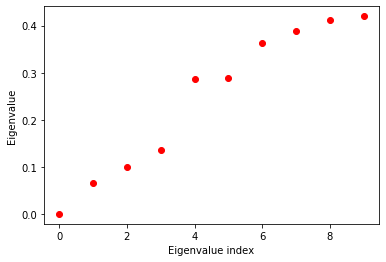

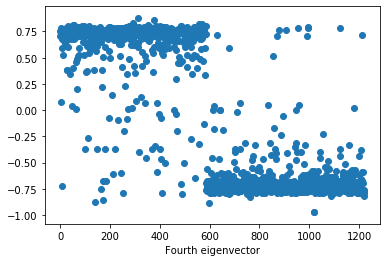

Cluster 1
***************
100monkeystyping.com --> True assignment.
12thharmonic.com/wordpress --> True assignment.
750volts.blogspot.com --> True assignment.
95theses.blogspot.com --> True assignment.
abbadabbaduo.blogspot.com --> True assignment.
aboutpolitics.blogspot.com --> True assignment.
achingandspinning.blogspot.com --> True assignment.
ackackack.com --> True assignment.
adviceforlefty.blogspot.com --> True assignment.
agonist.org --> True assignment.
aintnobaddude.com --> True assignment.
ajbenjaminjr.blogspot.com --> True assignment.
alicublog.blogspot.com --> True assignment.
allanjenkins.typepad.com --> True assignment.
allspinzone.blogspot.com --> True assignment.
alphapredator.com/wdtgw.htm --> True assignment.
alternateworlds.blogspot.com --> True assignment.
althippo.blogspot.com --> True assignment.
alvintostig.typepad.com --> True assignment.
americablog.blogspot.com --> True assignment.
americablog.org --> True assignment.
americanmuslim.blogs.com --> True assignme

In [6]:
# spectral clustering
n = len(name_list)
k = 2

v = np.ones((i.shape[0], 1)).flatten()

A = sparse.coo_matrix((v, (i, j)), shape=(n, n))
#Divided by 2 is used here.
A = (A + np.transpose(A))/2

    
#A1 is needed here to have the right D power to -1/2 matrix
D = np.diag(1/np.sqrt(np.sum(A, axis=1)).A1)
#@ is matrix multiplication operation symbol
#I - D@A@D
I = np.identity(n)
L = I - D @ A @ D

#np.linalg.eigh will return sorted value compared to np.linalg.eig.
#np.linalg.eigh uses a faster algorithm when matrix is symmetric.
v, x = np.linalg.eigh(L)

#plot first 10 eigenvalues
plt.plot(v.real[:10],'ro')
plt.ylabel('Eigenvalue')
plt.xlabel('Eigenvalue index')
plt.show()

x = x[:, 0:3].real
#x needs to be normalized here
#For example, if we are only using 2 eigenvectors for K-means: 
#Data point 1, new coordinates Z1 = (v1[0],v2[0]). Then v1[0] value is normalized by sqrt(v1[0]*v1[0]+v2[0]*v2[0])
x = x/np.repeat(np.sqrt(np.sum(x*x, axis=1).reshape(-1, 1)), 3, axis=1)
    
    
#plot first 4 eigenvectors
plt.scatter(x = np.arange(x.shape[0]), y = x[:, 2])
plt.xlabel('Fourth eigenvector')
plt.show()

# k-means
kmeans = KMeans(n_clusters=k).fit(x)
c_idx = kmeans.labels_


correct_count = 0
for l in range(k):
    print(f'Cluster {l+1}\n***************')
    idx = [index for index, t in enumerate(c_idx) if t == l]
    for index in idx:
        if l==int(label_list[index]): 
            correct_count +=1
        print(name_list[index] + " --> " + str(l==int(label_list[index])) + " assignment.")
    print('\n')
        
#Sometimes label 1 group are all assigned to label 2 
correct_count = max(correct_count, (n - correct_count))

print("Correct assignment count is " + str(correct_count))      
print('False classification rate is ' + str((n-correct_count)/len(name_list)))
